In [4]:
!pip install seaborn

  Using cached matplotlib-3.7.1-cp310-cp310-win_amd64.whl (7.6 MB)


In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [7]:
train['label'].value_counts()

0    867
2    859
5    853
3    852
1    848
4    722
Name: label, dtype: int64

<Axes: ylabel='count'>

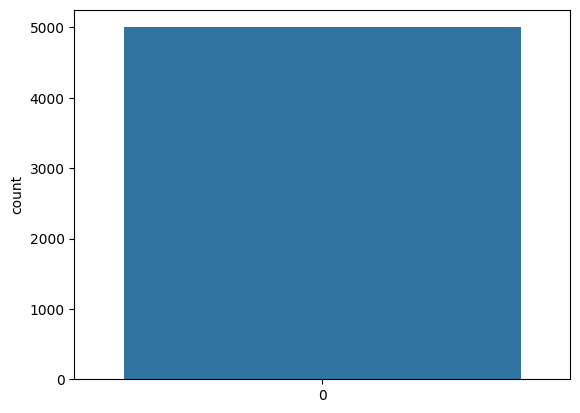

In [11]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

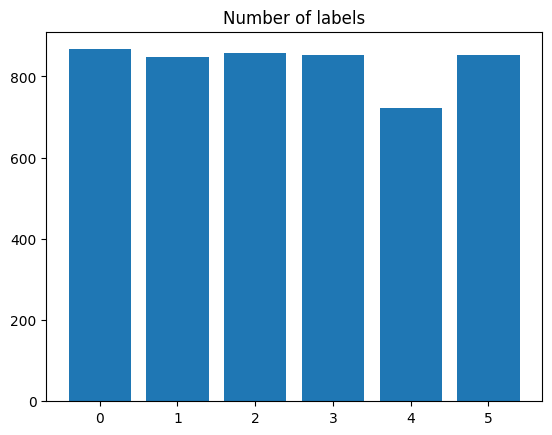

In [12]:
plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

In [13]:
from tqdm import tqdm

len_list = []

for i in tqdm(train.id):
    y, s = librosa.load('./train/' + i + '.wav')
    len_list.append(len(y)/s)

100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:16<00:00, 306.68it/s]


<Axes: title={'center': 'Length of audio'}, ylabel='Density'>

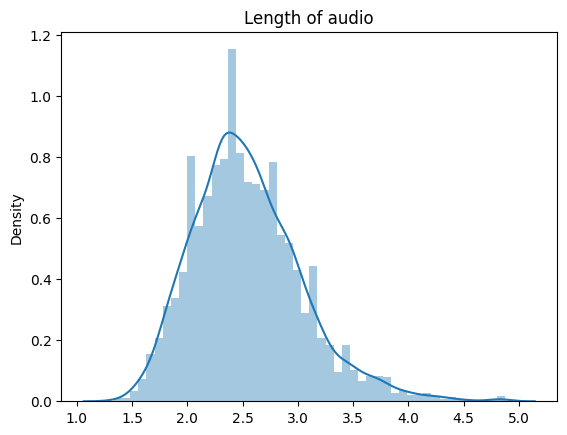

In [14]:
# len_list로 정규분포 확인
plt.title("Length of audio")
sns.distplot(len_list)

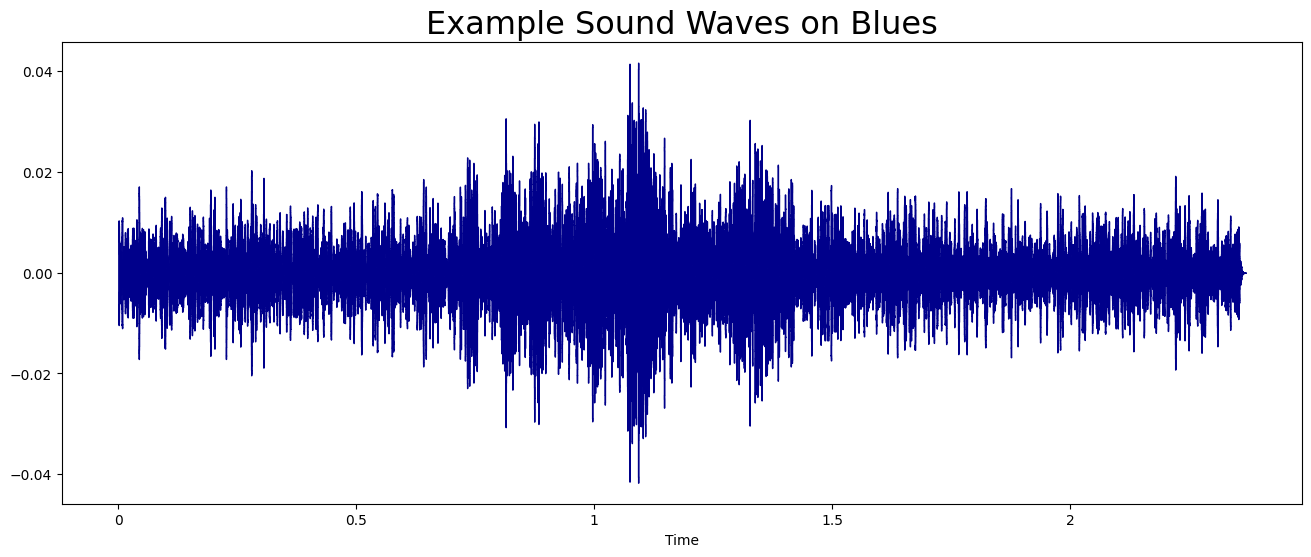

In [17]:
y,s = librosa.load('./train/TRAIN_0000.wav')

audio, _ = librosa.effects.trim(y)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

In [18]:
fft = 2048
hl = 512

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl))

print(np.shape(stft))

(1025, 103)


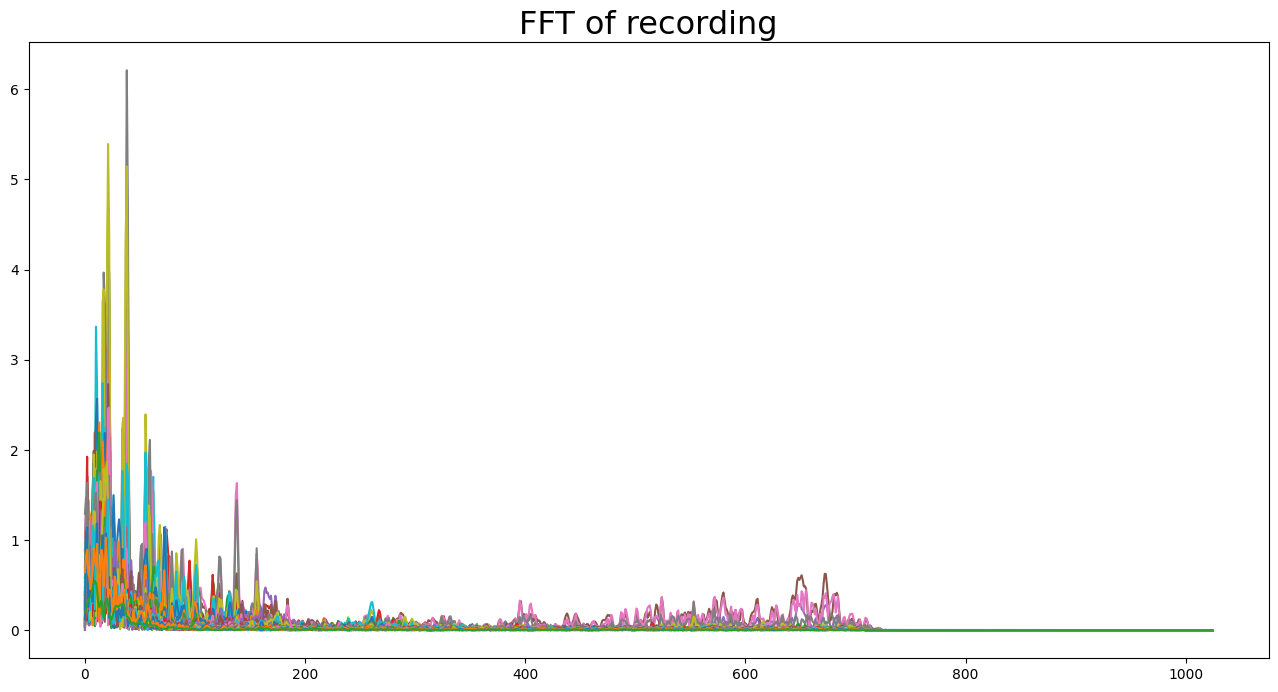

In [19]:
plt.figure(figsize = (16, 8))
plt.title("FFT of recording", fontsize = 23);
plt.plot(stft);

In [21]:
def Mel_s(num = 0, frame_length = 0.025, frame_stride = 0.010):
    sample = os.listdir('./train')
    temp = train[train.label == num].id
    file_name = temp[temp.index[0]]
    
    file = './train/' + file_name + '.wav'
    data,sample_rate = librosa.load(file, sr = 16000)
    
    input_nfft = int(round(sample_rate*frame_length))
    input_stride = int(round(sample_rate*frame_stride))
    
    S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(data)/sample_rate, np.shape(S)))
    
    S_dB  = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize = (14,5))
    librosa.display.specshow(S_dB, 
                             sr=sample_rate, 
                             hop_length=input_stride,
                             x_axis='time',
                             y_axis='log')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel spectrogram of audio label {num}")
    plt.show()

Wav length: 2.06875, Mel_S shape:(100, 207)


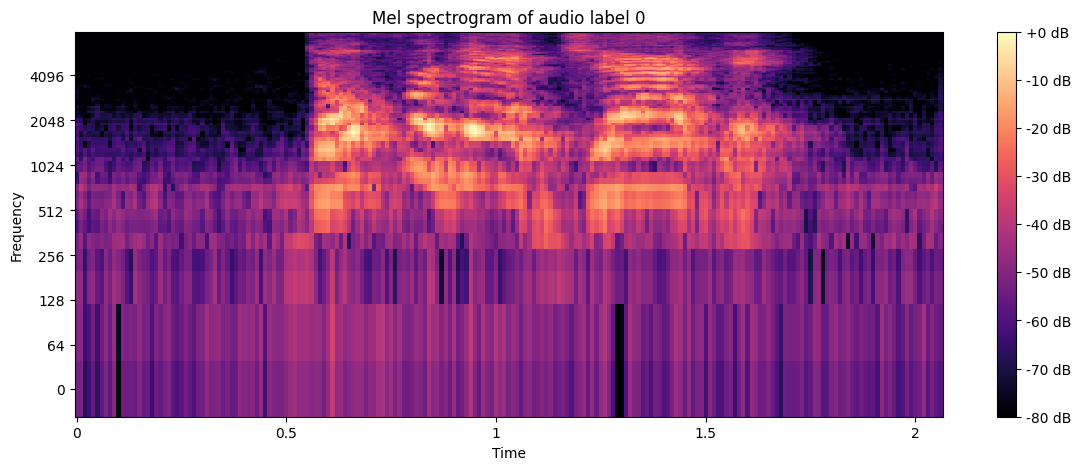

Wav length: 2.369, Mel_S shape:(100, 237)


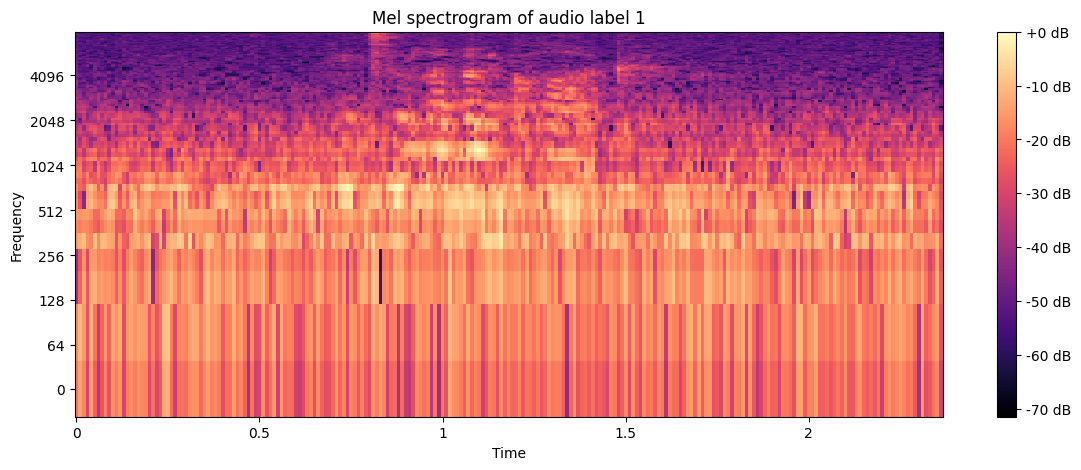

Wav length: 2.602625, Mel_S shape:(100, 261)


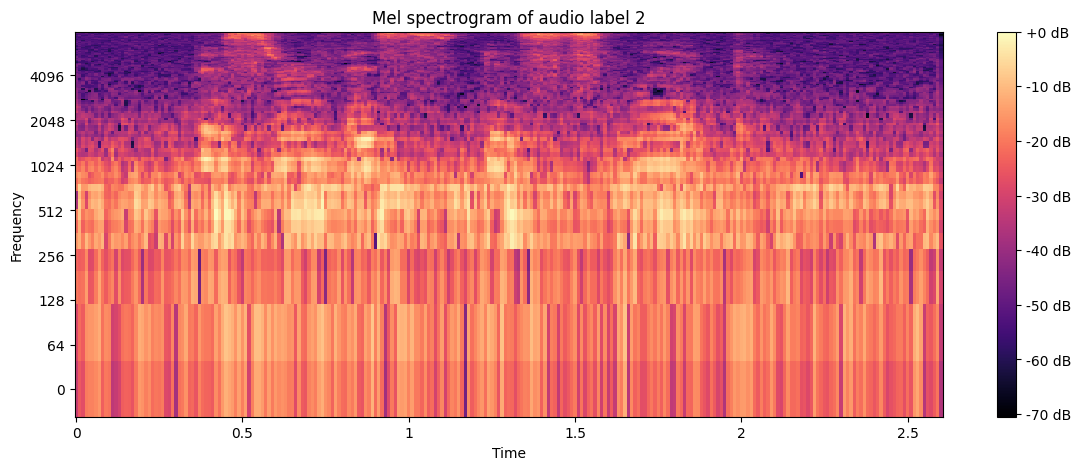

Wav length: 2.5025, Mel_S shape:(100, 251)


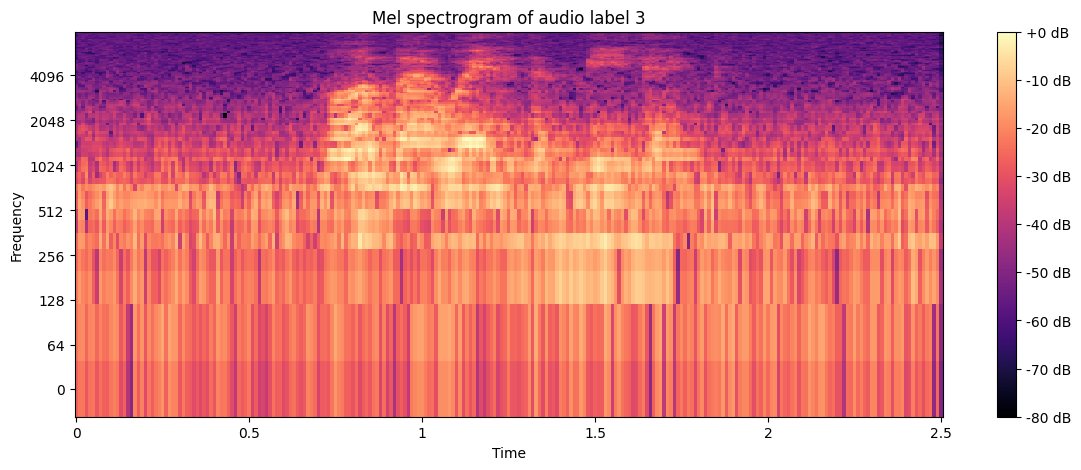

Wav length: 2.902875, Mel_S shape:(100, 291)


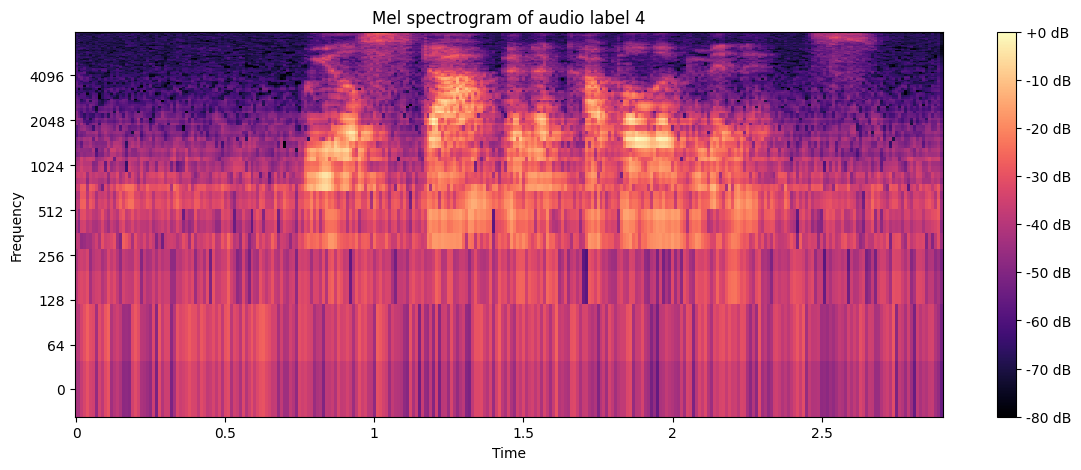

In [22]:
for i in range(0,5):
    Mel_s(i)

In [88]:
mfcc_features = []
mel_spec_features = []
D_features = []
normal_mfcc_features = []
normal_mel_features = []
for i in tqdm(range(len(test))):
  y, sr = librosa.load('test/'+f'TEST_{str(i).zfill(4)}.wav',sr=44100)
  D = np.abs(librosa.stft(y))
  mel_spec = librosa.feature.melspectrogram(y=y, sr=44100)
  mfcc = librosa.feature.mfcc(y=y, sr=44100,n_mfcc=40)
  normalized_mfcc = librosa.util.normalize(mfcc)
  normalized_mel_spec = librosa.util.normalize(mel_spec)
  

  a_feature = []
  b_feature = []
  c_feature = []
  d_feature = []
  e_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
  for e in mfcc:
     a_feature.append(np.mean(e))
  mfcc_features.append(a_feature)

        # 추출된 Mel_spec들의 평균을 Feature로 사용
  for e in mel_spec:
     b_feature.append(np.mean(e))
  mel_spec_features.append(b_feature)

        # 추출된 D들의 평균을 Feature로 사용
  for e in D:
     c_feature.append(np.mean(e))
  D_features.append(c_feature)

          # 추출된 normalized_mfcc들의 평균을 Feature로 사용
  for e in normalized_mfcc:
     d_feature.append(np.mean(e))
  normal_mfcc_features.append(d_feature)

          # 추출된 normalized_mel_spec들의 평균을 Feature로 사용
  for e in normalized_mel_spec:
     e_feature.append(np.mean(e))
  normal_mel_features.append(e_feature)

100%|██████████████████████████████████████████████████████████████████████████████| 1881/1881 [02:16<00:00, 13.78it/s]


In [89]:
print(D.shape,mel_spec.shape,mfcc.shape,normalized_mel_spec.shape,normalized_mfcc.shape)

(1025, 161) (128, 161) (40, 161) (128, 161) (40, 161)


In [90]:
mfcc_df = pd.DataFrame(mfcc_features, columns=['mfcc_'+str(x) for x in range(1,41)])
mel_spec_df = pd.DataFrame(mel_spec_features, columns=['mel_spec_'+str(x) for x in range(1,129)])
D_df = pd.DataFrame(D_features, columns=['D_'+str(x) for x in range(1,1026)])
normal_mfcc_df = pd.DataFrame(normal_mfcc_features, columns=['normal_mfcc_'+str(x) for x in range(1,41)])
normal_mel_df = pd.DataFrame(normal_mel_features, columns=['normal_mel_'+str(x) for x in range(1,129)])

In [91]:
x_test = pd.concat([mfcc_df,mel_spec_df],axis=1)
print(x_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Columns: 168 entries, mfcc_1 to mel_spec_128
dtypes: float32(168)
memory usage: 1.2 MB
None


In [100]:
mfcc_features = []
mel_spec_features = []
D_features = []
normal_mfcc_features = []
normal_mel_features = []
for i in tqdm(range(len(train))):
  y, sr = librosa.load('train/'+f'TRAIN_{str(i).zfill(4)}.wav',sr=44100)
  D = np.abs(librosa.stft(y))
  mel_spec = librosa.feature.melspectrogram(y=y, sr=44100)
  mfcc = librosa.feature.mfcc(y=y, sr=44100,n_mfcc=40)
  normalized_mfcc = librosa.util.normalize(mfcc)
  normalized_mel_spec = librosa.util.normalize(mel_spec)
  

  a_feature = []
  b_feature = []
  c_feature = []
  d_feature = []
  e_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
  for e in mfcc:
     a_feature.append(np.mean(e))
  mfcc_features.append(a_feature)

        # 추출된 Mel_spec들의 평균을 Feature로 사용
  for e in mel_spec:
     b_feature.append(np.mean(e))
  mel_spec_features.append(b_feature)

        # 추출된 D들의 평균을 Feature로 사용
  for e in D:
     c_feature.append(np.mean(e))
  D_features.append(c_feature)

          # 추출된 normalized_mfcc들의 평균을 Feature로 사용
  for e in normalized_mfcc:
     d_feature.append(np.mean(e))
  normal_mfcc_features.append(d_feature)

          # 추출된 normalized_mel_spec들의 평균을 Feature로 사용
  for e in normalized_mel_spec:
     e_feature.append(np.mean(e))
  normal_mel_features.append(e_feature)

100%|██████████████████████████████████████████████████████████████████████████████| 5001/5001 [08:06<00:00, 10.27it/s]


In [101]:
print(D.shape,mel_spec.shape,mfcc.shape,normalized_mel_spec.shape,normalized_mfcc.shape)

(1025, 271) (128, 271) (40, 271) (128, 271) (40, 271)


In [119]:
mfcc_df = pd.DataFrame(mfcc_features, columns=['mfcc_'+str(x) for x in range(1,41)])
mel_spec_df = pd.DataFrame(mel_spec_features, columns=['mel_spec_'+str(x) for x in range(1,129)])
D_df = pd.DataFrame(D_features, columns=['D_'+str(x) for x in range(1,1026)])
normal_mfcc_df = pd.DataFrame(normal_mfcc_features, columns=['normal_mfcc_'+str(x) for x in range(1,41)])
normal_mel_df = pd.DataFrame(normal_mel_features, columns=['normal_mel_'+str(x) for x in range(1,129)])

In [120]:
x_train = pd.concat([mfcc_df,mel_spec_df],axis=1)
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Columns: 168 entries, mfcc_1 to mel_spec_128
dtypes: float32(168)
memory usage: 3.2 MB
None


In [43]:
x_train_normal = pd.concat([normal_mfcc_df,normal_mel_df],axis =1)
print(x_train_normal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Columns: 168 entries, normal_mfcc_1 to normal_mel_128
dtypes: float32(168)
memory usage: 3.2 MB
None


In [46]:
x_train.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_spec_119,mel_spec_120,mel_spec_121,mel_spec_122,mel_spec_123,mel_spec_124,mel_spec_125,mel_spec_126,mel_spec_127,mel_spec_128
0,-531.695190,202.475250,-19.667307,64.620209,18.085896,-8.649203,32.079288,-12.481881,0.996818,11.706519,...,3.114208e-09,2.822529e-09,2.557263e-09,2.322784e-09,2.122782e-09,1.956945e-09,1.826402e-09,1.727630e-09,1.659772e-09,1.619818e-09
1,-521.528809,191.967361,-35.225643,78.740288,23.666927,-5.548991,37.559593,-18.268393,3.025454,13.216597,...,1.088069e-09,9.857248e-10,8.926648e-10,8.104167e-10,7.402783e-10,6.821392e-10,6.363901e-10,6.017885e-10,5.780244e-10,5.640374e-10
2,-436.175720,162.547836,-5.023142,50.701969,16.028397,-11.061485,16.977106,-8.794944,-2.310059,0.849998,...,2.853254e-09,2.580669e-09,2.333283e-09,2.115006e-09,1.929121e-09,1.775233e-09,1.654253e-09,1.562858e-09,1.500127e-09,1.463230e-09
3,-450.940369,144.717529,27.860312,36.790833,20.552032,-2.325379,3.823058,-2.038857,1.977299,-0.528164,...,1.986990e-09,1.798737e-09,1.627658e-09,1.476553e-09,1.347767e-09,1.241075e-09,1.157157e-09,1.093728e-09,1.050183e-09,1.024566e-09
4,-422.536682,144.337387,24.411663,32.070168,24.831940,4.352208,4.063816,-7.281356,-4.079869,-3.249997,...,3.246538e-09,2.938731e-09,2.659119e-09,2.412217e-09,2.201813e-09,2.027515e-09,1.890425e-09,1.786803e-09,1.715656e-09,1.673799e-09


In [59]:
x_train['label'] = train['label']
x_train.head()

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,mel_spec_120,mel_spec_121,mel_spec_122,mel_spec_123,mel_spec_124,mel_spec_125,mel_spec_126,mel_spec_127,mel_spec_128,label
0,-531.695190,202.475250,-19.667307,64.620209,18.085896,-8.649203,32.079288,-12.481881,0.996818,11.706519,...,2.822529e-09,2.557263e-09,2.322784e-09,2.122782e-09,1.956945e-09,1.826402e-09,1.727630e-09,1.659772e-09,1.619818e-09,1
1,-521.528809,191.967361,-35.225643,78.740288,23.666927,-5.548991,37.559593,-18.268393,3.025454,13.216597,...,9.857248e-10,8.926648e-10,8.104167e-10,7.402783e-10,6.821392e-10,6.363901e-10,6.017885e-10,5.780244e-10,5.640374e-10,2
2,-436.175720,162.547836,-5.023142,50.701969,16.028397,-11.061485,16.977106,-8.794944,-2.310059,0.849998,...,2.580669e-09,2.333283e-09,2.115006e-09,1.929121e-09,1.775233e-09,1.654253e-09,1.562858e-09,1.500127e-09,1.463230e-09,4
3,-450.940369,144.717529,27.860312,36.790833,20.552032,-2.325379,3.823058,-2.038857,1.977299,-0.528164,...,1.798737e-09,1.627658e-09,1.476553e-09,1.347767e-09,1.241075e-09,1.157157e-09,1.093728e-09,1.050183e-09,1.024566e-09,5
4,-422.536682,144.337387,24.411663,32.070168,24.831940,4.352208,4.063816,-7.281356,-4.079869,-3.249997,...,2.938731e-09,2.659119e-09,2.412217e-09,2.201813e-09,2.027515e-09,1.890425e-09,1.786803e-09,1.715656e-09,1.673799e-09,4


In [61]:
x_train_normal['label'] = train['label']
x_train_normal.head()

,normal_mfcc_1,normal_mfcc_2,normal_mfcc_3,normal_mfcc_4,normal_mfcc_5,normal_mfcc_6,normal_mfcc_7,normal_mfcc_8,normal_mfcc_9,normal_mfcc_10,...,normal_mel_120,normal_mel_121,normal_mel_122,normal_mel_123,normal_mel_124,normal_mel_125,normal_mel_126,normal_mel_127,normal_mel_128,label
0,-1.00000,0.383392,-0.038334,0.121295,0.033458,-0.016757,0.060705,-0.023630,0.001771,0.021814,...,3.301411e-08,2.991256e-08,2.717091e-08,2.483228e-08,2.289303e-08,2.136638e-08,2.021117e-08,1.941745e-08,1.895009e-08,1
1,-1.00000,0.370153,-0.071452,0.153045,0.045082,-0.010999,0.073406,-0.036400,0.006080,0.025620,...,9.169248e-09,8.304067e-09,7.539379e-09,6.887241e-09,6.346620e-09,5.921165e-09,5.599337e-09,5.378279e-09,5.248154e-09,2
2,-1.00000,0.398216,-0.023418,0.116792,0.033776,-0.032692,0.038702,-0.022119,-0.005569,0.000409,...,9.201566e-08,8.319959e-08,7.542064e-08,6.879565e-08,6.331058e-08,5.899798e-08,5.573956e-08,5.350282e-08,5.218706e-08,4
3,-1.00000,0.349704,0.049039,0.081498,0.043944,-0.012791,0.005756,-0.008494,0.003849,-0.002195,...,2.526500e-08,2.286295e-08,2.074130e-08,1.893295e-08,1.743473e-08,1.625622e-08,1.536536e-08,1.475373e-08,1.439388e-08,5
4,-0.99866,0.368728,0.050245,0.071911,0.058736,0.007782,0.006550,-0.021529,-0.010934,-0.009460,...,2.050826e-08,1.855759e-08,1.683508e-08,1.536714e-08,1.415105e-08,1.319449e-08,1.247141e-08,1.197489e-08,1.168276e-08,4


In [65]:
from sklearn.model_selection import train_test_split
X, Y = x_train.drop(['label'], axis=1),x_train['label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [66]:
from sklearn.model_selection import train_test_split
X_nor, Y_nor = x_train_normal.drop(['label'], axis=1),x_train_normal['label']
X_train_nor, X_test_nor, y_train_nor, y_test_nor = train_test_split(X_nor, Y_nor, test_size=0.2, random_state=43, shuffle=True)

In [69]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)

SVC()

In [74]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.3806193806193806

In [80]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train_nor, y_train_nor)

SVC()

In [81]:
pred = model.predict(X_test_nor)
score = accuracy_score(y_test_nor,pred)
score

0.4075924075924076

In [94]:
from xgboost import XGBClassifier
import xgboost as xgb
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [77]:
pred = model.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.5084915084915085

In [95]:
pred = model.predict(x_test)

In [97]:
sub = pd.read_csv('sample_submission.csv')
sub['label'] = pred
sub.head()

,id,label
0,TEST_0000,5
1,TEST_0001,0
2,TEST_0002,2
3,TEST_0003,1
4,TEST_0004,5


In [98]:
sub.to_csv('sub_xgb_gird2.csv', index = False)

In [82]:
model = xgb.XGBClassifier()
model.fit(X_train_nor, y_train_nor)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [84]:
pred = model.predict(X_test_nor)
score = accuracy_score(y_test_nor,pred)
score

0.4975024975024975

In [78]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(iterations = 300,learning_rate=0.1,
                                    depth=4,loss_function='MultiClass')
cat_model.fit(X_train,y_train)

0:	learn: 1.7425172	total: 217ms	remaining: 1m 4s
1:	learn: 1.6931665	total: 244ms	remaining: 36.4s
2:	learn: 1.6577020	total: 272ms	remaining: 26.9s
3:	learn: 1.6263190	total: 299ms	remaining: 22.2s
4:	learn: 1.5988473	total: 327ms	remaining: 19.3s
5:	learn: 1.5745098	total: 355ms	remaining: 17.4s
6:	learn: 1.5529360	total: 383ms	remaining: 16s
7:	learn: 1.5330062	total: 412ms	remaining: 15s
8:	learn: 1.5181037	total: 441ms	remaining: 14.2s
9:	learn: 1.5052473	total: 473ms	remaining: 13.7s
10:	learn: 1.4901878	total: 502ms	remaining: 13.2s
11:	learn: 1.4779196	total: 530ms	remaining: 12.7s
12:	learn: 1.4677425	total: 559ms	remaining: 12.3s
13:	learn: 1.4584997	total: 586ms	remaining: 12s
14:	learn: 1.4504591	total: 616ms	remaining: 11.7s
15:	learn: 1.4441514	total: 643ms	remaining: 11.4s
16:	learn: 1.4368021	total: 673ms	remaining: 11.2s
17:	learn: 1.4298094	total: 705ms	remaining: 11.1s
18:	learn: 1.4244246	total: 733ms	remaining: 10.8s
19:	learn: 1.4189893	total: 761ms	remaining: 10

167:	learn: 1.1030279	total: 5.16s	remaining: 4.06s
168:	learn: 1.1016139	total: 5.19s	remaining: 4.02s
169:	learn: 1.1002345	total: 5.23s	remaining: 4s
170:	learn: 1.0991575	total: 5.26s	remaining: 3.97s
171:	learn: 1.0972230	total: 5.29s	remaining: 3.93s
172:	learn: 1.0957465	total: 5.32s	remaining: 3.9s
173:	learn: 1.0948441	total: 5.35s	remaining: 3.87s
174:	learn: 1.0931065	total: 5.38s	remaining: 3.84s
175:	learn: 1.0914025	total: 5.41s	remaining: 3.81s
176:	learn: 1.0906286	total: 5.44s	remaining: 3.78s
177:	learn: 1.0889160	total: 5.47s	remaining: 3.75s
178:	learn: 1.0868854	total: 5.5s	remaining: 3.72s
179:	learn: 1.0856665	total: 5.53s	remaining: 3.68s
180:	learn: 1.0845054	total: 5.55s	remaining: 3.65s
181:	learn: 1.0837147	total: 5.58s	remaining: 3.62s
182:	learn: 1.0823701	total: 5.62s	remaining: 3.59s
183:	learn: 1.0810461	total: 5.64s	remaining: 3.56s
184:	learn: 1.0793715	total: 5.67s	remaining: 3.53s
185:	learn: 1.0782536	total: 5.7s	remaining: 3.49s
186:	learn: 1.0773

In [79]:
pred = cat_model.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.4875124875124875

In [85]:
cat_model = CatBoostClassifier(iterations = 300,learning_rate=0.1,
                                    depth=4,loss_function='MultiClass')
cat_model.fit(X_train_nor,y_train_nor)

0:	learn: 1.7487634	total: 34.9ms	remaining: 10.4s
1:	learn: 1.7125890	total: 63.6ms	remaining: 9.47s
2:	learn: 1.6785602	total: 91ms	remaining: 9.01s
3:	learn: 1.6530077	total: 118ms	remaining: 8.74s
4:	learn: 1.6261513	total: 146ms	remaining: 8.62s
5:	learn: 1.6058466	total: 175ms	remaining: 8.56s
6:	learn: 1.5887677	total: 202ms	remaining: 8.47s
7:	learn: 1.5723271	total: 230ms	remaining: 8.41s
8:	learn: 1.5578034	total: 260ms	remaining: 8.41s
9:	learn: 1.5440408	total: 293ms	remaining: 8.49s
10:	learn: 1.5301187	total: 321ms	remaining: 8.43s
11:	learn: 1.5184434	total: 349ms	remaining: 8.38s
12:	learn: 1.5059970	total: 377ms	remaining: 8.33s
13:	learn: 1.4977790	total: 405ms	remaining: 8.28s
14:	learn: 1.4886119	total: 434ms	remaining: 8.24s
15:	learn: 1.4794593	total: 462ms	remaining: 8.2s
16:	learn: 1.4690156	total: 497ms	remaining: 8.27s
17:	learn: 1.4608617	total: 525ms	remaining: 8.23s
18:	learn: 1.4543297	total: 553ms	remaining: 8.17s
19:	learn: 1.4472909	total: 582ms	remaini

167:	learn: 1.1035666	total: 4.94s	remaining: 3.88s
168:	learn: 1.1020639	total: 4.97s	remaining: 3.85s
169:	learn: 1.1013159	total: 5s	remaining: 3.82s
170:	learn: 1.0999064	total: 5.03s	remaining: 3.79s
171:	learn: 1.0983800	total: 5.06s	remaining: 3.76s
172:	learn: 1.0965712	total: 5.09s	remaining: 3.73s
173:	learn: 1.0948861	total: 5.12s	remaining: 3.7s
174:	learn: 1.0928075	total: 5.15s	remaining: 3.68s
175:	learn: 1.0917058	total: 5.18s	remaining: 3.65s
176:	learn: 1.0904807	total: 5.21s	remaining: 3.62s
177:	learn: 1.0893199	total: 5.23s	remaining: 3.59s
178:	learn: 1.0882610	total: 5.26s	remaining: 3.56s
179:	learn: 1.0872537	total: 5.29s	remaining: 3.52s
180:	learn: 1.0852200	total: 5.32s	remaining: 3.5s
181:	learn: 1.0837876	total: 5.34s	remaining: 3.46s
182:	learn: 1.0826540	total: 5.37s	remaining: 3.43s
183:	learn: 1.0806593	total: 5.4s	remaining: 3.4s
184:	learn: 1.0794807	total: 5.43s	remaining: 3.37s
185:	learn: 1.0781928	total: 5.45s	remaining: 3.34s
186:	learn: 1.07726

In [86]:
pred = cat_model.predict(X_test_nor)
score = accuracy_score(y_test_nor,pred)
score

0.4985014985014985

In [124]:
!pip install tensorflow

ERROR: Could not install packages due to an OSError: [WinError 32] 다른 프로세스가 파일을 사용 중이기 때문에 프로세스가 액세스 할 수 없습니다: 'C:\\anaconda\\Lib\\site-packages\\tensorboard\\compat\\proto\\saver_pb2.py'
Consider using the `--user` option or check the permissions.



     ------------------------------------ 272.8/272.8 MB 603.1 kB/s eta 0:00:00
     -------------------------------------- 24.4/24.4 MB 626.0 kB/s eta 0:00:00
     -------------------------------------- 65.5/65.5 kB 876.9 kB/s eta 0:00:00
     ------------------------------------ 440.7/440.7 kB 688.8 kB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 769.8 kB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 1.8 MB/s eta 0:00:00
     ------------------------------------ 422.5/422.5 kB 356.6 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 546.1 kB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 351.0 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metad

In [125]:
import tensorflow as tf
from tensorflow.keras import layers

In [136]:
input_shape = (x_train.shape[1],)  # Specify the input shape based on the number of MFCC features
model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=input_shape),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(6, activation='softmax')
])

ValueError: Input 0 of layer "bidirectional_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 168)

In [141]:
import tensorflow as tf
from tensorflow.keras import layers

input_shape = x_train.shape[1:]  # Use slicing to remove the first dimension (batch size)

model = tf.keras.Sequential([
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=input_shape),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(6, activation='softmax')
])

ValueError: Input 0 of layer "bidirectional_12" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 168)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

In [ ]:
pred = model.predict(x_test)

In [ ]:
sub['label'] = pred
sub.head()

In [ ]:
sub.to_csv('sub_BLSTM.csv', index = False)

# list 안에 array.ndarray 형식으로 저장되어 있음
list는 5001개
ex) mfcc_feature[3000].shape = (40, 268) # 40 = n_mfcc 값

In [24]:
audio_dir = 'train/'
mfcc_feature = []
for i in tqdm(range(len(train))):
    sig, sr = librosa.load(audio_dir+f'TRAIN_{str(i).zfill(4)}.wav',sr=44100)
    fft = np.fft.fft(sig)
    magnitude = np.abs(fft)
    f = np.linspace(0,sr,len(magnitude))
    left_spectrum = magnitude[:int(len(magnitude)/2)]
    left_f = f[:int(len(magnitude)/2)]
    hop_length = 512  # 전체 frame 수
    n_fft = 2048
    hop_length_duration = float(hop_length)/sr
    n_fft_duration = float(n_fft)/sr
    stft = librosa.stft(sig, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    log_spectrogram = librosa.amplitude_to_db(magnitude)
    MFCCs = librosa.feature.mfcc(y = sig, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=40)
    mfcc_feature.append(MFCCs)
               
               
               
    

100%|██████████████████████████████████████████████████████████████████████████████| 5001/5001 [06:37<00:00, 12.58it/s]


In [25]:
mfcc_feature[3000].shape

(40, 268)

In [27]:
mfcc_feature[3000].T.shape

(268, 40)

In [68]:
mfcc_feature[3000]

array([[-5.5173822e+02, -5.2972870e+02, -5.2614130e+02, ...,
        -5.2312927e+02, -5.3791083e+02, -6.0477972e+02],
       [ 1.6699818e+02,  1.7664653e+02,  1.8145410e+02, ...,
         1.8227504e+02,  1.8004141e+02,  1.5609155e+02],
       [-4.4077711e+00, -1.3154373e+01, -1.0283438e+01, ...,
        -1.2138088e+01,  3.5256512e+00,  2.8981724e+01],
       ...,
       [ 7.3261863e-01, -1.9501483e+00, -2.5160782e+00, ...,
         5.2305138e-01,  1.1657817e+00,  3.9122055e+00],
       [ 3.6192467e+00,  1.1667371e+00, -1.4632766e+00, ...,
         6.8742423e+00,  3.1817431e+00,  1.2192789e+00],
       [-5.0310097e+00, -6.4528351e+00, -7.6238136e+00, ...,
         1.4162271e+00, -2.0648856e+00,  1.7908370e-01]], dtype=float32)

In [30]:
mfcc_feature[5000].shape

(40, 271)

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [33]:
mfcc_feature[1].__class__

numpy.ndarray